<a href="https://colab.research.google.com/github/Sujoy-004/diabetes-risk-ml/blob/main/diabetes_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### impport and install data

In [1]:
!pip install xgboost shap scikit-learn pandas matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
print("done")

done


### Load and inspect data

In [2]:
# Load dataset with error handling
try:
    df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv')
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("-" * 40)
except Exception as e:
    print(f"Error loading dataset: {e}")

# Display first few rows
print("First 5 rows:")
print(df.head().to_string(index=False))
print()

# Dataset info
print("Dataset Information:")
df.info()
print()

# Statistical summary
print("Statistical Summary:")
print(df.describe().to_string())
print()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print()

# Check for duplicates
print(f"Duplicate rows: {df.duplicated().sum()}")

Dataset loaded successfully!
Shape: (768, 9)
----------------------------------------
First 5 rows:
 Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DiabetesPedigreeFunction  Age  Outcome
           6      148             72             35        0 33.6                     0.627   50        1
           1       85             66             29        0 26.6                     0.351   31        0
           8      183             64              0        0 23.3                     0.672   32        1
           1       89             66             23       94 28.1                     0.167   21        0
           0      137             40             35      168 43.1                     2.288   33        1

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies            

### code and impute data

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# Replace 0s with NaN in invalid columns
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print(f"Replacing 0s with NaN in columns: {cols_with_zero}")
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Show NaN count before and after replacement
print("\nMissing values after replacing 0s with NaN:")
missing_counts = df.isnull().sum()
print(missing_counts[missing_counts > 0].to_string())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Impute missing values using KNN Imputer
print("\nImputing missing values using KNN (k=5)...")
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Verify no missing values after imputation
print(f"Missing values after imputation: {df_imputed.isnull().sum().sum()}")

# Show comparison of original vs imputed data
print("\nComparison - Original vs Imputed (first 5 rows):")
print("Original data:")
print(df[cols_with_zero].head().to_string())
print("\nImputed data:")
print(df_imputed[cols_with_zero].head().to_string())

Replacing 0s with NaN in columns: ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

Missing values after replacing 0s with NaN:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11

Total missing values: 652

Imputing missing values using KNN (k=5)...
Missing values after imputation: 0

Comparison - Original vs Imputed (first 5 rows):
Original data:
   Glucose  BloodPressure  SkinThickness  Insulin   BMI
0    148.0           72.0           35.0      NaN  33.6
1     85.0           66.0           29.0      NaN  26.6
2    183.0           64.0            NaN      NaN  23.3
3     89.0           66.0           23.0     94.0  28.1
4    137.0           40.0           35.0    168.0  43.1

Imputed data:
   Glucose  BloodPressure  SkinThickness  Insulin   BMI
0    148.0           72.0           35.0    169.0  33.6
1     85.0           66.0           29.0     58.6  26.6
2    183.0           64.0           25.8    164.6  23.3
3     

### scale featuring

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Separate features and target
feature_cols = df_imputed.columns[:-1]  # All columns except the last one
X_original = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

print(f"Features to scale: {list(feature_cols)}")
print(f"Target variable: Outcome")
print(f"Original feature shape: {X_original.shape}")

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)
X = pd.DataFrame(X_scaled, columns=feature_cols)

print(f"Scaled feature shape: {X.shape}")

# Show scaling results
print("\nOriginal features (first 3 rows):")
print(X_original.head(3).to_string())
print("\nScaled features (first 3 rows):")
print(X.head(3).to_string())

# Verify scaling worked correctly
print(f"\nScaled features mean (should be ~0): \n{X.mean().round(10).to_string()}")
print(f"\nScaled features std (should be ~1): \n{X.std().round(3).to_string()}")

print(f"\nTarget distribution: {y.value_counts().to_string()}")

Features to scale: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target variable: Outcome
Original feature shape: (768, 8)
Scaled feature shape: (768, 8)

Original features (first 3 rows):
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction   Age
0          6.0    148.0           72.0           35.0    169.0  33.6                     0.627  50.0
1          1.0     85.0           66.0           29.0     58.6  26.6                     0.351  31.0
2          8.0    183.0           64.0           25.8    164.6  23.3                     0.672  32.0

Scaled features (first 3 rows):
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  DiabetesPedigreeFunction       Age
0     0.639947  0.866296      -0.030443       0.624914  0.160899  0.170392                  0.468492  1.425995
1    -0.844885 -1.200858      -0.522308      -0.012166 -0.961951 -0.846739          

### split

In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train-Test Split completed!")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[1]}")

# Verify stratification worked
print("\nTarget distribution verification:")
print("Training set distribution:")
train_dist = y_train.value_counts(normalize=True).sort_index()
print(train_dist.to_string())

print("\nTest set distribution:")
test_dist = y_test.value_counts(normalize=True).sort_index()
print(test_dist.to_string())

print("\nOriginal dataset distribution:")
orig_dist = y.value_counts(normalize=True).sort_index()
print(orig_dist.to_string())

print(f"\nSplit ratio: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}% train, {len(X_test)/(len(X_train)+len(X_test))*100:.1f}% test")

Train-Test Split completed!
Training set size: 614 samples
Test set size: 154 samples
Feature dimensions: 8

Target distribution verification:
Training set distribution:
Outcome
0.0    0.651466
1.0    0.348534

Test set distribution:
Outcome
0.0    0.649351
1.0    0.350649

Original dataset distribution:
Outcome
0.0    0.651042
1.0    0.348958

Split ratio: 79.9% train, 20.1% test


### Model evaluation

In [6]:
# Train XGBoost model
print("Training XGBoost model...")
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
print("XGBoost model training complete.")

Training XGBoost model...
XGBoost model training complete.


Evaluating XGBoost model...
Accuracy: 0.7273
Precision: 0.6304
Recall: 0.5370
F1-score: 0.5800
AUC: 0.7969

Confusion Matrix:
[[83 17]
 [25 29]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80       100
         1.0       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154



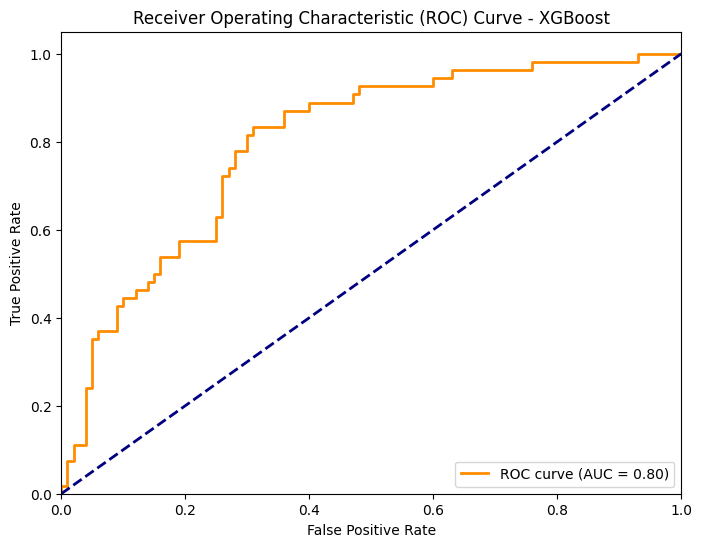

In [7]:
# Evaluate XGBoost model
print("Evaluating XGBoost model...")
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")
print(f"AUC: {roc_auc_xgb:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

Training Logistic Regression model...
Logistic Regression model training complete.

Evaluating Logistic Regression model...
Accuracy: 0.6948
Precision: 0.5745
Recall: 0.5000
F1-score: 0.5347
AUC: 0.8146

Confusion Matrix:
[[80 20]
 [27 27]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       100
         1.0       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



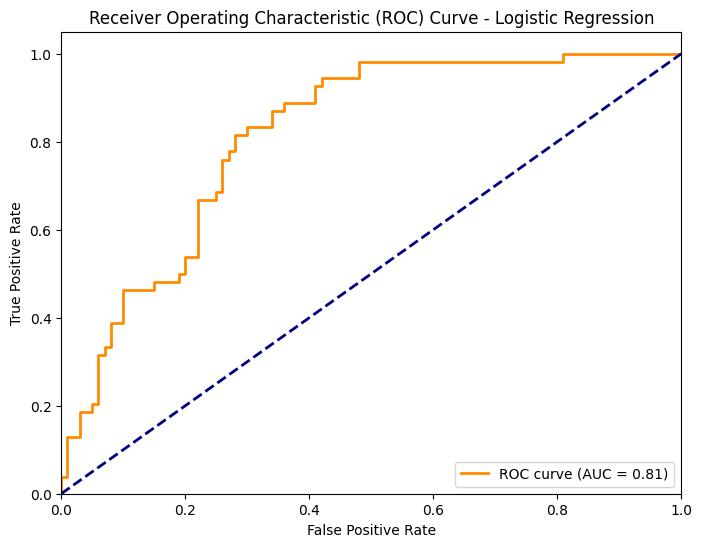

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve)
import matplotlib.pyplot as plt

# Train Logistic Regression model
print("Training Logistic Regression model...")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
print("Logistic Regression model training complete.")

# Evaluate Logistic Regression model
print("\nEvaluating Logistic Regression model...")
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")
print(f"AUC: {roc_auc_lr:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# ROC Curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Training Random Forest model...
Random Forest model training complete.

Evaluating Random Forest model...
Accuracy: 0.7078
Precision: 0.5957
Recall: 0.5185
F1-score: 0.5545
AUC: 0.8071

Confusion Matrix:
[[81 19]
 [26 28]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.81      0.78       100
         1.0       0.60      0.52      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



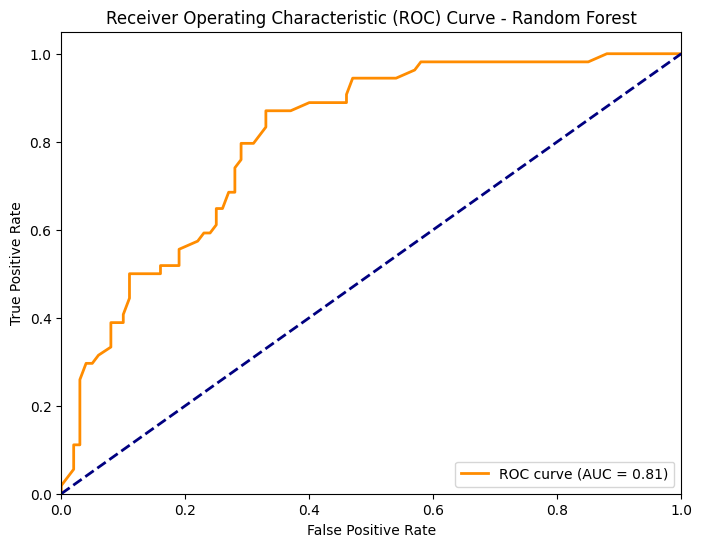

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("Random Forest model training complete.")

# Evaluate Random Forest model
print("\nEvaluating Random Forest model...")
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")
print(f"AUC: {roc_auc_rf:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

Training SVM model...
SVM model training complete.

Evaluating SVM model...
Accuracy: 0.7338
Precision: 0.6444
Recall: 0.5370
F1-score: 0.5859
AUC: 0.7976

Confusion Matrix:
[[84 16]
 [25 29]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.80       100
         1.0       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154



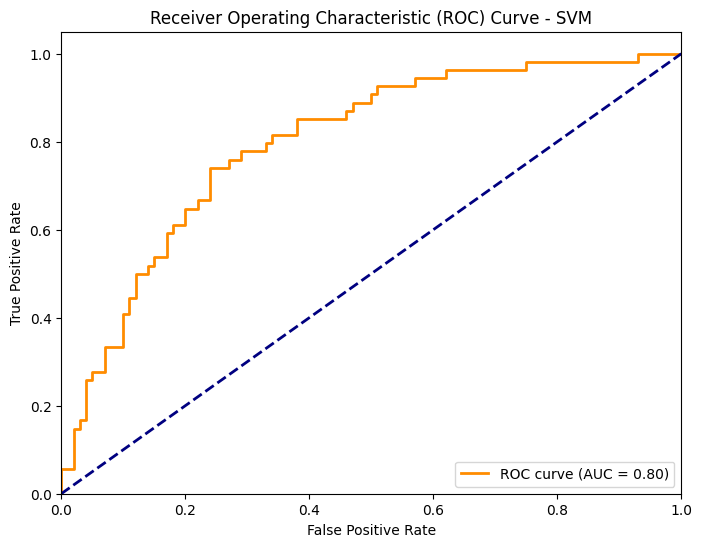

In [10]:
from sklearn.svm import SVC

# Train SVM model
print("Training SVM model...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)
print("SVM model training complete.")

# Evaluate SVM model
print("\nEvaluating SVM model...")
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm)

print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-score: {f1_svm:.4f}")
print(f"AUC: {roc_auc_svm:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(cm_svm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# ROC Curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc="lower right")
plt.show()

In [11]:
# Create a dictionary to store metrics for each model
metrics_data = {
    'XGBoost': {
        'Accuracy': accuracy_xgb,
        'Precision': precision_xgb,
        'Recall': recall_xgb,
        'F1-score': f1_xgb,
        'AUC': roc_auc_xgb
    },
    'Logistic Regression': {
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr,
        'F1-score': f1_lr,
        'AUC': roc_auc_lr
    },
    'Random Forest': {
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1-score': f1_rf,
        'AUC': roc_auc_rf
    },
    'SVM': {
        'Accuracy': accuracy_svm,
        'Precision': precision_svm,
        'Recall': recall_svm,
        'F1-score': f1_svm,
        'AUC': roc_auc_svm
    }
}

# Convert the dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data).T

# Print the comparison DataFrame
print("Model Performance Comparison:")
display(metrics_df.round(4))

Model Performance Comparison:


,Accuracy,Precision,Recall,F1-score,AUC
XGBoost,0.7273,0.6304,0.5370,0.5800,0.7969
Logistic Regression,0.6948,0.5745,0.5000,0.5347,0.8146
Random Forest,0.7078,0.5957,0.5185,0.5545,0.8071
SVM,0.7338,0.6444,0.5370,0.5859,0.7976


## Summary:

### Data Analysis Key Findings

*   The Logistic Regression model achieved an accuracy of 0.6948, precision of 0.5745, recall of 0.5000, F1-score of 0.5347, and AUC of 0.8146.
*   The Random Forest model achieved an accuracy of 0.7078, precision of 0.5957, recall of 0.5185, F1-score of 0.5545, and AUC of 0.8071.
*   The SVM model achieved an accuracy of 0.7338, precision of 0.6444, recall of 0.5370, F1-score of 0.5859, and AUC of 0.7976.
*   Based on the comparison table, the SVM model generally shows the best performance across Accuracy, Precision, and F1-score, while the Logistic Regression model has the highest AUC.

